# Analyse non supervisée

In [1]:
import pandas as pd
import math
from tabulate import tabulate
import numpy as np
import random
from typing import List
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_completeness_v_measure

Importation de data deja pre-traite

In [2]:
df = pd.read_csv('agriculture.csv')
df.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
0,0.264264,0.435115,0.552288,0.458716,0.560000,0.512821,0.371469,0.250000,0.009671,0.338308,0.449321,0.056818,0.512821,0.0
1,0.489489,0.351145,0.189542,0.605505,0.733333,0.820513,0.487698,0.338235,0.062863,0.721393,0.145246,0.606163,0.820513,0.0
2,0.339339,0.511450,0.810458,0.577982,0.413333,0.863248,0.964689,0.338235,0.062863,0.736318,0.135319,0.606163,0.863248,0.0
3,0.321321,0.297710,0.413399,0.623853,0.506667,0.717949,0.487698,0.397059,0.031915,0.716418,0.132706,0.606163,0.717949,0.0
4,0.660661,0.534351,0.362745,0.614679,0.266667,0.649573,0.788136,0.264706,0.053191,0.796020,0.121212,0.606163,0.649573,1.0


In [4]:
df.shape

(880, 14)

In [5]:
df1 = df.copy()

In [6]:
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)

In [7]:
df.shape

(880, 11)

In [5]:
true_labels = pd.read_csv('agriculture.csv')['Fertility']

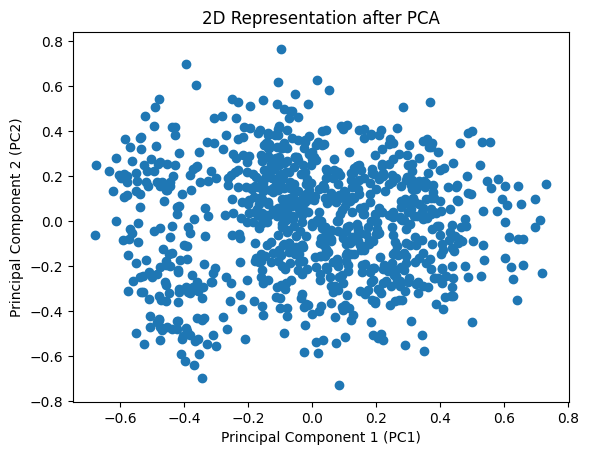

In [6]:
X = df[df.columns]
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
df_2d = pd.DataFrame(data=X_2d, columns=['PC1', 'PC2'])
plt.scatter(df_2d['PC1'], df_2d['PC2'])
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('2D Representation after PCA')
plt.show()

In [49]:
#pip install scikit-learn

In [50]:
#pip install sklearn

Application d’algorithme de clustering basé partitionnement (K-means)

In [7]:
def calcule_centroide(instances):
    if not instances:
        raise ValueError("Instances list is empty")
    num_dimensions = len(instances[0])
    somme = [0] * num_dimensions
    for instance in instances:
        for i in range(num_dimensions):
            somme[i] += instance[i]
    moyenne = [s / len(instances) for s in somme]
    return moyenne

In [8]:
def calcule_distance_euclidienne(A, B):
    distance = 0
    for i in range(len(A)):
        distance = distance + (A[i] - B[i])**2
    return round(math.sqrt(distance),2)    

In [9]:
def initialise_centroides(instances, k):
    return random.sample(list(instances), k)

les instances ayant des distances plus grandes ont des probabilités plus élevées d'être choisies comme prochains centroids.

In [10]:
def initialize_centroids_kmeans_plusplus(instances, k):
    centroids = [random.choice(instances)]
    
    while len(centroids) < k:
        distances = np.array([min(np.linalg.norm(np.array(instance) - np.array(centroid)) ** 2 for centroid in centroids) for instance in instances])
        
        probabilities = distances / sum(distances)
        next_centroid = random.choices(instances, probabilities)[0]
        centroids.append(next_centroid)
    
    return centroids


In [11]:
def k_means(instances, k, max_iterations=100, convergence_threshold=1e-4):
    if k <= 0:
        raise ValueError("Invalid number of clusters or empty dataset")

    centroides = initialize_centroids_kmeans_plusplus(instances, k)

    for _ in range(max_iterations):
        clusters = [[] for _ in range(k)]

        # Assigner chaque instance au cluster le plus proche
        for i, instance in enumerate(instances):
            distances = [calcule_distance_euclidienne(instance, centroid) for centroid in centroides]
            closest_cluster_index = distances.index(min(distances))
            clusters[closest_cluster_index].append(i)

        # Calculer les nouveaux centroides
        new_centroides = [calcule_centroide([instances[i] for i in cluster]) for cluster in clusters]

        # Vérifier la convergence en utilisant la variation de la somme des carrés des distances intra-cluster
        variation = np.sum((np.array(new_centroides) - np.array(centroides)) ** 2)
        if variation < convergence_threshold:
            break

        centroides = new_centroides

    # Assigner chaque instance au cluster correspondant
    instance_clusters = [-1] * len(instances)
    for cluster_index, cluster in enumerate(clusters):
        for instance_index in cluster:
            instance_clusters[instance_index] = cluster_index

    return instance_clusters, centroides


In [12]:
def visualize_clusters(instances, KMeans_Labels, centroides):
    # Instancier l'objet PCA
    pca = PCA(n_components=2)

    # Appliquer l'ACP sur les données normalisées
    pca_result = pca.fit_transform(instances)

    # Visualiser les résultats du K-means avec les deux premières composantes principales
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=KMeans_Labels, cmap='viridis', edgecolors='k')
    plt.scatter(np.array(centroides)[:, 0], np.array(centroides)[:, 1], c='red', marker='X', s=200, label='Centroides')
    plt.title('K-means Clustering (PCA)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

la courbe du coude

En examinant ces valeurs, on peut constater qu'il y a une réduction significative de l'erreur jusqu'au nombre de clusters de 3, après quoi la réduction ralentit. Cela suggère que le coude pourrait se situer autour de 3 clusters. Cependant, l'identification du coude peut être subjective et dépend de la pente spécifique de votre courbe.

In [14]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
instances = df_scaled

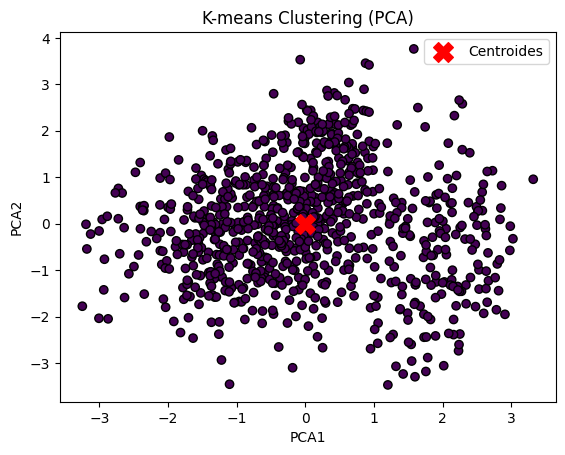

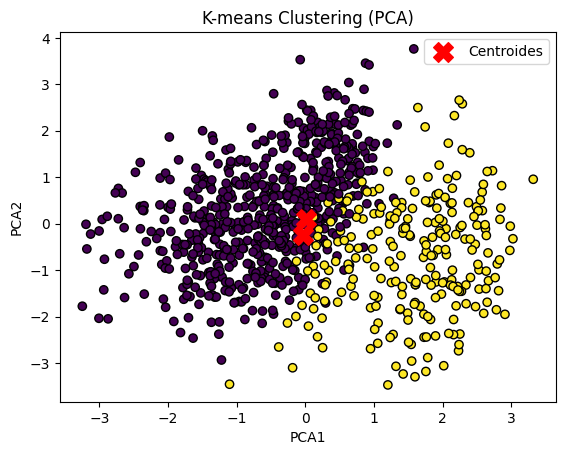

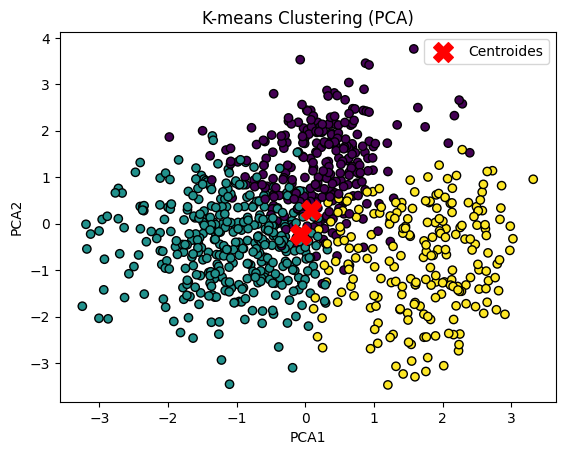

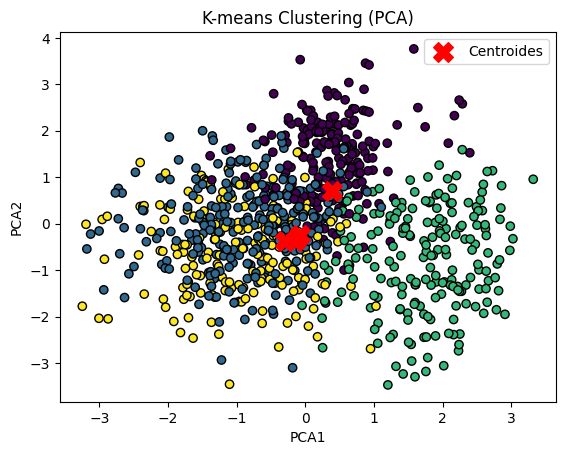

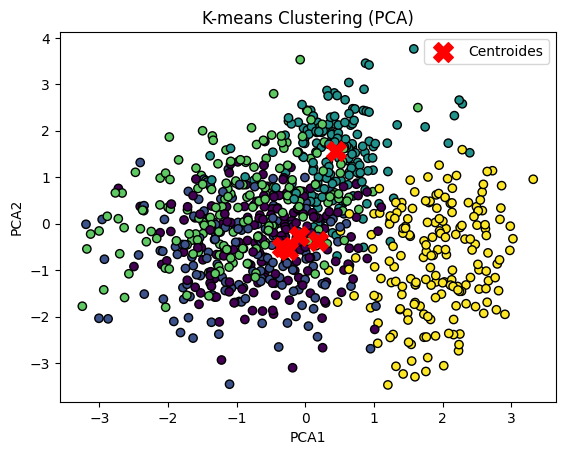

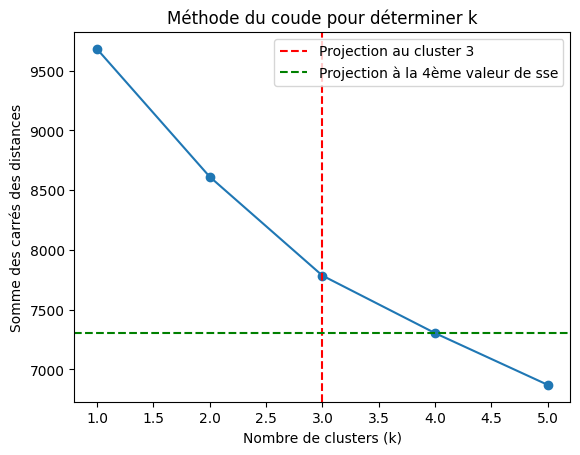

In [15]:
sse = []
for k in range(1, 6):
    instance_clusters, centroides = k_means(instances, k)
    visualize_clusters(instances, instance_clusters, centroides)

    # Calculez la somme des carrés des distances (inertie)
    inertia = 0
    for i, instance in enumerate(instances):
        centroid = calcule_centroide([instances[j] for j in range(len(instances)) if instance_clusters[j] == instance_clusters[i]])
        inertia += calcule_distance_euclidienne(instance, centroid) ** 2
    sse.append(inertia)

plt.plot(range(1, 6), sse, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Somme des carrés des distances')
plt.title('Méthode du coude pour déterminer k')

chosen_k = 3
plt.axvline(x=chosen_k, color='red', linestyle='--', label=f'Projection au cluster {chosen_k}')
fourth_sse_value = sse[3]
plt.axhline(y=fourth_sse_value, color='green', linestyle='--', label=f'Projection à la 4ème valeur de sse')
plt.legend()
plt.show()


In [300]:
#instances = df.iloc[:, :].values.tolist()
#df['Cluster'], centroides = k_means(instances, 3)
#df

Experementation

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

iteration = [50, 100, 150, 200, 300, 450]
convergence = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-5]
results = []  # Liste pour stocker les résultats

for i in iteration:
    for j in convergence:
        df = pd.read_csv('agriculture.csv')
        df = df.drop(['Fertility', 'OC', 'OM'], axis=1)

        # Pour scaler les données
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        instances = df_scaled
        max_homogeneity = 0

        # Utilisation de votre fonction k_means (assurez-vous que votre fonction est correctement définie)
        for k in range(5):
            instance_clusters, centroides = k_means(instances, 3, i, j)
            df['Cluster'] = instance_clusters

            # Calcul des métriques
            h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(true_labels, df['Cluster'])
            silhouette_avg_sklearn = silhouette_score(df, df['Cluster'])

            if h_kmeans > max_homogeneity:
                max_homogeneity = h_kmeans
                # Stockage des résultats dans une liste
                result_entry = {'Iterations': i, 'Convergence': j, 'Homogeneity': h_kmeans, 'Completeness': c_kmeans,
                                'V_measure': v_kmeans, 'Silhouette': silhouette_avg_sklearn}
        
        # Stocker seulement le résultat maximum d'homogénéité pour chaque combinaison d'itération et de convergence
        results.append(result_entry)

In [521]:
from tabulate import tabulate

table_headers = ["Iterations", "Convergence", "Homogeneity", "Completeness", "V_measure", "Silhouette"]
table_data = []

for result_entry in results:
    table_row = [
        result_entry['Iterations'],
        result_entry['Convergence'],
        round(result_entry['Homogeneity'], 4),
        round(result_entry['Completeness'], 4),
        round(result_entry['V_measure'], 4),
        round(result_entry['Silhouette'], 4)
    ]
    table_data.append(table_row)

print(tabulate(table_data, headers=table_headers, tablefmt="grid"))


+--------------+---------------+---------------+----------------+-------------+--------------+
|   Iterations |   Convergence |   Homogeneity |   Completeness |   V_measure |   Silhouette |
+==============+===============+===============+================+=============+==============+
|           50 |        0.1    |        0.1603 |         0.1235 |      0.1395 |       0.3929 |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.01   |        0.1851 |         0.1467 |      0.1637 |       0.4116 |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.001  |        0.0659 |         0.0598 |      0.0627 |       0.394  |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.0001 |        0.0113 |         0.009  |      0.01   |       0.4023 |
+--------------+---------------+---------------+--

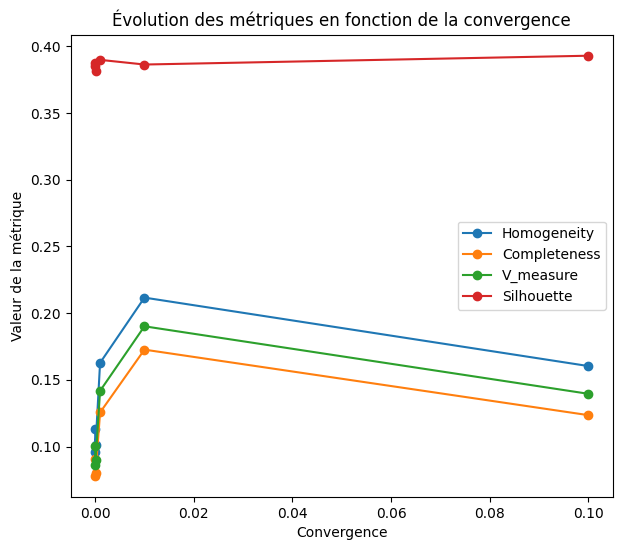

In [16]:
import matplotlib.pyplot as plt

# Données
iterations = [50, 100, 150, 200, 300, 450]
convergence_values = [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-05]
homogeneity = [0.1603, 0.2116, 0.1627, 0.1014, 0.0962, 0.1133]
completeness = [0.1235, 0.1726, 0.1255, 0.0805, 0.0781, 0.0905]
v_measure = [0.1395, 0.1901, 0.1417, 0.0898, 0.0862, 0.1006]
silhouette = [0.3929, 0.3863, 0.3898, 0.3811, 0.3871, 0.3854]

# Création du graphique
plt.figure(figsize=(7, 6))

plt.plot(convergence_values, homogeneity, marker='o', label='Homogeneity')
plt.plot(convergence_values, completeness, marker='o', label='Completeness')
plt.plot(convergence_values, v_measure, marker='o', label='V_measure')
plt.plot(convergence_values, silhouette, marker='o', label='Silhouette')

plt.title('Évolution des métriques en fonction de la convergence')
plt.xlabel('Convergence')
plt.ylabel('Valeur de la métrique')
plt.legend()
plt.show()


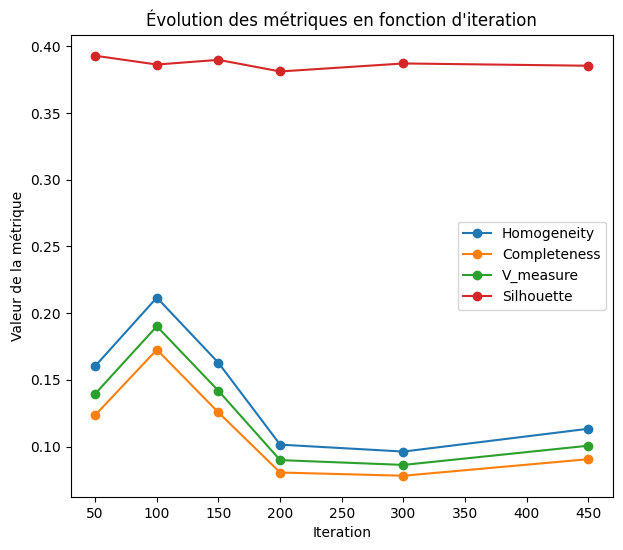

In [17]:
import matplotlib.pyplot as plt

# Données
iterations = [50, 100, 150, 200, 300, 450]
convergence_values = [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-05]
homogeneity = [0.1603, 0.2116, 0.1627, 0.1014, 0.0962, 0.1133]
completeness = [0.1235, 0.1726, 0.1255, 0.0805, 0.0781, 0.0905]
v_measure = [0.1395, 0.1901, 0.1417, 0.0898, 0.0862, 0.1006]
silhouette = [0.3929, 0.3863, 0.3898, 0.3811, 0.3871, 0.3854]

# Création du graphique
plt.figure(figsize=(7, 6))

plt.plot(iterations, homogeneity, marker='o', label='Homogeneity')
plt.plot(iterations, completeness, marker='o', label='Completeness')
plt.plot(iterations, v_measure, marker='o', label='V_measure')
plt.plot(iterations, silhouette, marker='o', label='Silhouette')

plt.title('Évolution des métriques en fonction d\'iteration')
plt.xlabel('Iteration')
plt.ylabel('Valeur de la métrique')
plt.legend()
plt.show()


Mesurer-Coefficient de silhouette

Homogeneity 0.1563, Completeness 0.1323, V_measure 0.1433
Indice de silhouette moyen : 0.3881653923411978
0.14773869514465332


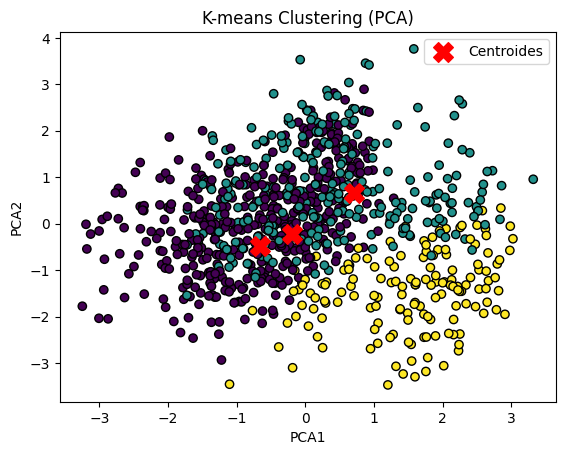

In [146]:
from sklearn.metrics import silhouette_score
df = pd.read_csv('agriculture.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)
# pour scaler les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
instances = df_scaled
import time
debut = time.time()
instance_clusters, centroides = k_means(instances, 3, 100, 0.01)
fin = time.time()
df['Cluster'] = instance_clusters
h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(true_labels, df['Cluster'])
print(f'Homogeneity {round(h_kmeans,4)}, Completeness {round(c_kmeans,4)}, V_measure {round(v_kmeans,4)}')
silhouette_avg_sklearn = silhouette_score(df, df['Cluster'])
print("Indice de silhouette moyen :", silhouette_avg_sklearn)
temps_execution = fin - debut
print(temps_execution)

visualize_clusters(instances, instance_clusters, centroides)
df['Cluster'] = instance_clusters

In [18]:
result_silhouette = []

for k in range(1, 6):
    instance_clusters, centroides = k_means(instances, 3, 100, 0.01)

    #instance_clusters, centroides = k_means(instances, k)    
    df['Cluster'] = instance_clusters
    silhouette_avg = silhouette_score(df, df['Cluster'])
    result_silhouette.append(round(silhouette_avg,2))
print(result_silhouette) 


[0.4, 0.41, 0.39, 0.39, 0.41]


Stabilité des clusters

apres qu'on a pu fixer les parametres de k-means

In [19]:
def k_means_stability(instances, k, num_iterations=10, max_iterations=100, convergence=1e-4):
    if k <= 0 or not instances.any():
        raise ValueError("Invalid number of clusters or empty dataset")

    all_instance_clusters = []
    all_centroides = []

    for _ in range(num_iterations):
        # Créer un échantillon bootstrap
        bootstrap_sample = np.random.choice(len(instances), size=len(instances), replace=True)
        instances_bootstrap = instances[bootstrap_sample]

        centroides = initialize_centroids_kmeans_plusplus(instances_bootstrap, k)

        for _ in range(max_iterations):
            clusters = [[] for _ in range(k)]
            for i, instance in enumerate(instances_bootstrap):
                distances = [calcule_distance_euclidienne(instance, centroid) for centroid in centroides]
                closest_cluster_index = distances.index(min(distances))
                clusters[closest_cluster_index].append(i)

            new_centroides = [calcule_centroide([instances_bootstrap[i] for i in cluster]) for cluster in clusters]

            if np.array_equal(new_centroides, centroides):
                break
            centroides = new_centroides

        instance_clusters = [-1] * len(instances)
        for cluster_index, cluster in enumerate(clusters):
            for instance_index in cluster:
                instance_clusters[instance_index] = cluster_index

        all_instance_clusters.append(instance_clusters)
        all_centroides.append(centroides)
    return all_instance_clusters, all_centroides


In [20]:
df = pd.read_csv('agriculture.csv')
df = df.drop(['Fertility', 'OC', 'OM'], axis=1)

# Pour scaler les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
instances = df_scaled
I, C = k_means_stability(instances, 3, 10, 100, 0.01)

In [21]:
def plot_cluster_stability(all_instance_clusters):
    n_iterations = len(all_instance_clusters)
    n_instances = len(all_instance_clusters[0])

    cluster_frequencies = np.zeros((n_instances, n_iterations))

    for i, clusters in enumerate(all_instance_clusters):
        for j, cluster_index in enumerate(clusters):
            cluster_frequencies[j, i] = cluster_index
    
    #print(cluster_frequencies)
    plt.imshow(cluster_frequencies, cmap='viridis', aspect='auto')
    plt.xlabel('Iteration')
    plt.ylabel('Instance Index')
    plt.title('Cluster Assignment Stability')
    plt.show()


Cela crée une matrice où chaque colonne représente une itération, chaque ligne représente une instance

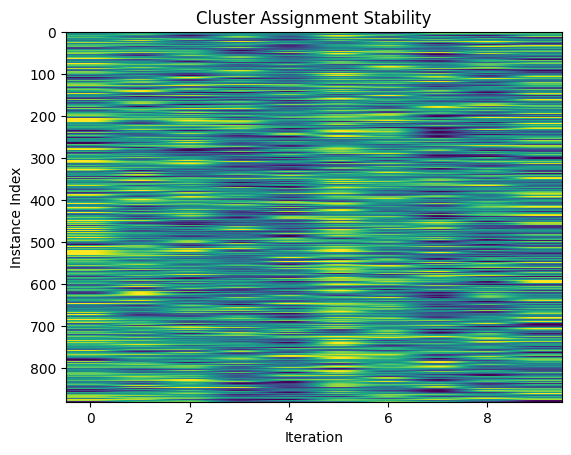

In [22]:
plot_cluster_stability(I)

Chaque ligne dans l'image représente une instance, chaque colonne représente une itération, et la couleur de chaque pixel représente l'index du cluster auquel l'instance est attribuée pour cette itération.

In [23]:
def analyze_instance_stability(instance_index, all_instance_clusters):
    n_iterations = len(all_instance_clusters)
    cluster_assignments = [clusters[instance_index] for clusters in all_instance_clusters]

    plt.plot(range(n_iterations), cluster_assignments, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cluster Assignment')
    plt.title(f'Cluster Assignment Stability for Instance {instance_index}')
    plt.show()

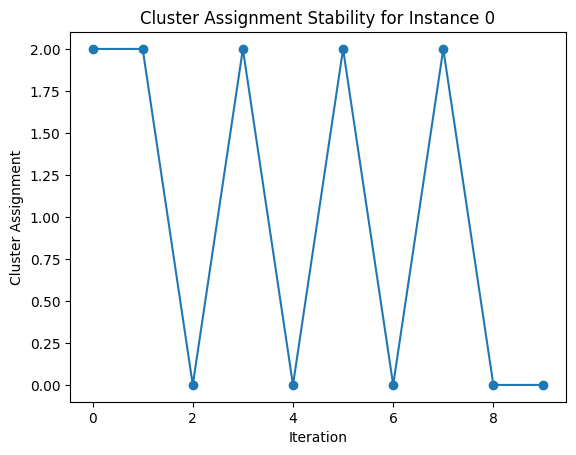

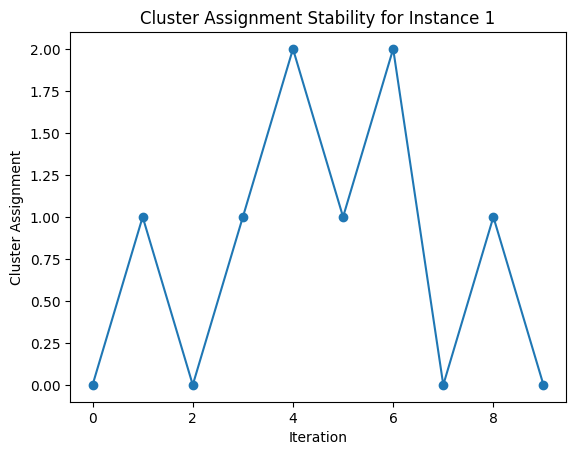

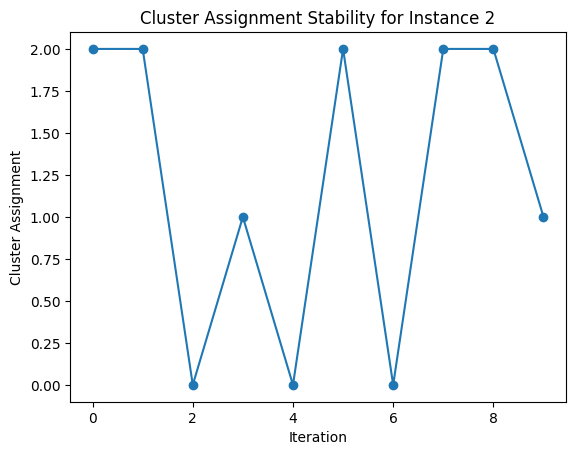

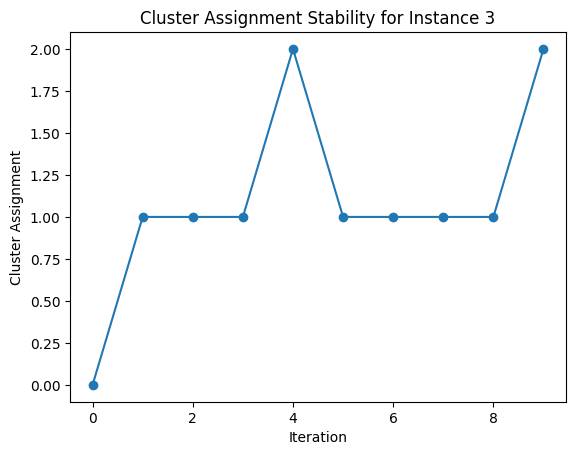

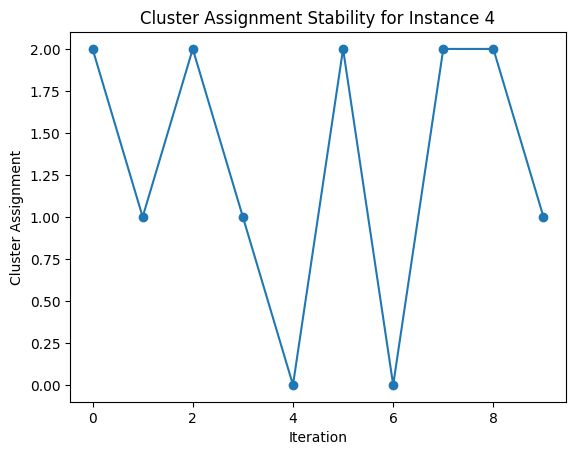

In [24]:
for i in range(5):
    analyze_instance_stability(i,I)

In [25]:
def plot_centroid_stability(all_centroides):
    n_iterations = len(all_centroides)
    n_dimensions = len(all_centroides[0][0])
    centroid_positions = np.zeros((n_dimensions, n_iterations, len(all_centroides[0])))
    for i, centroids in enumerate(all_centroides):
        for j, centroid in enumerate(centroids):
            centroid_positions[:, i, j] = centroid
    for dim in range(n_dimensions):
        plt.imshow(centroid_positions[dim, :, :], cmap='viridis', aspect='auto')
        plt.xlabel('Iteration')
        plt.ylabel(f'clusters')
        plt.title(f'Position Stability')
        plt.show()

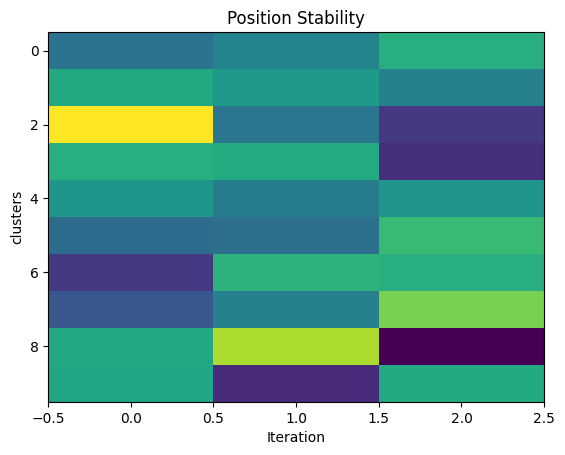

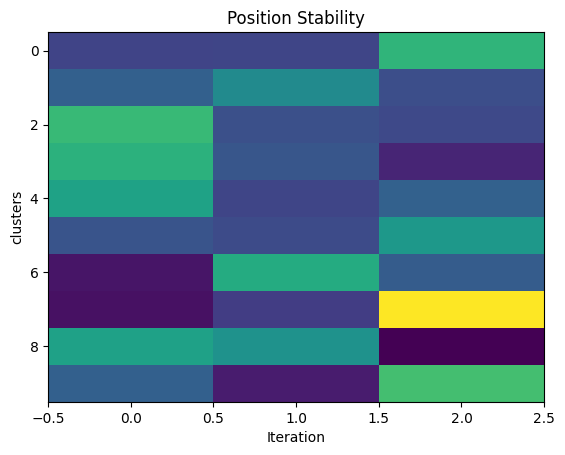

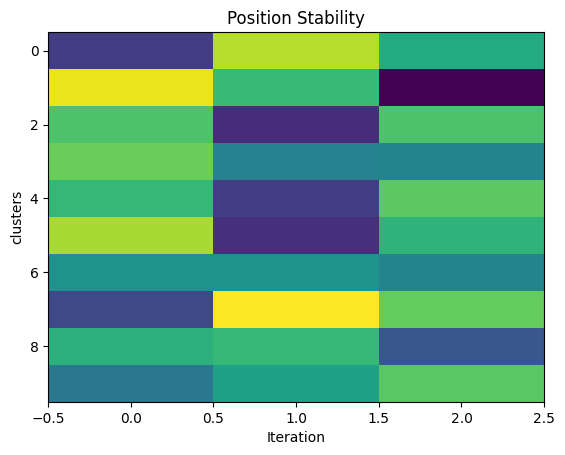

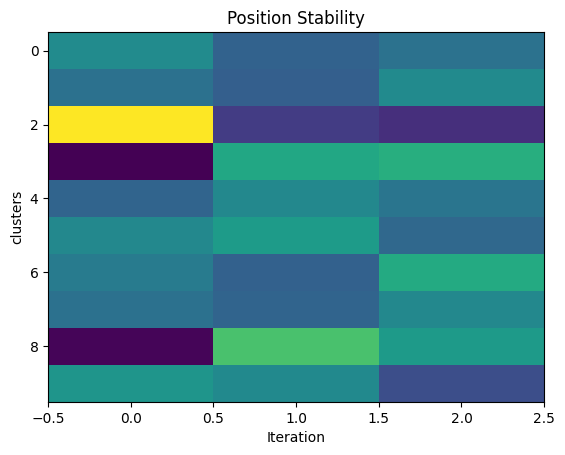

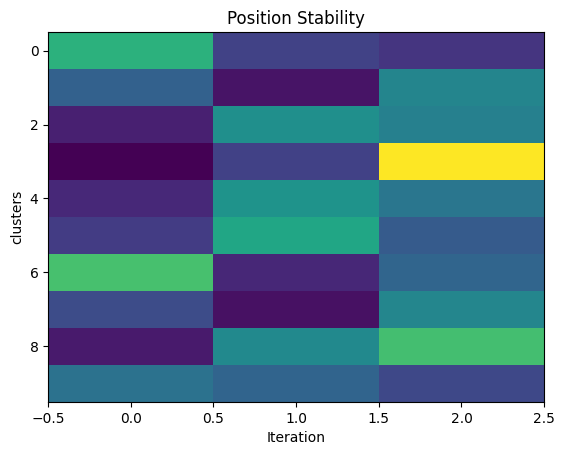

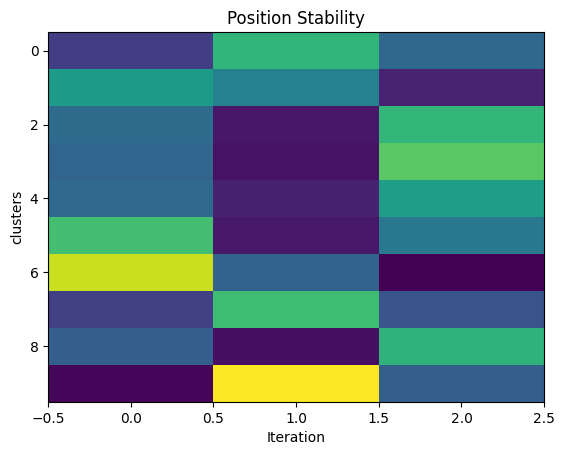

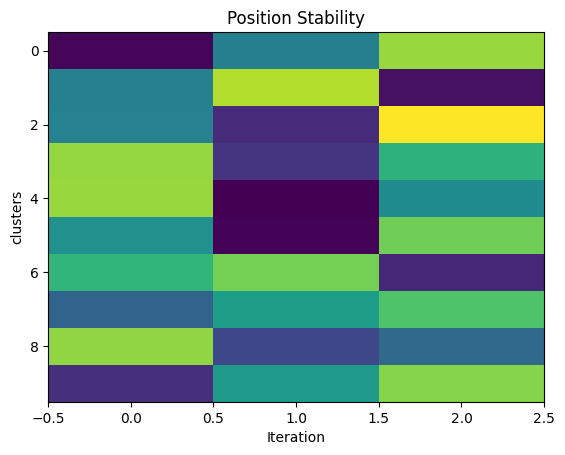

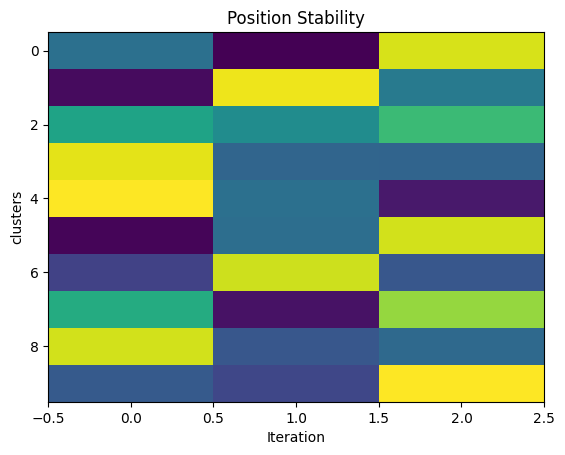

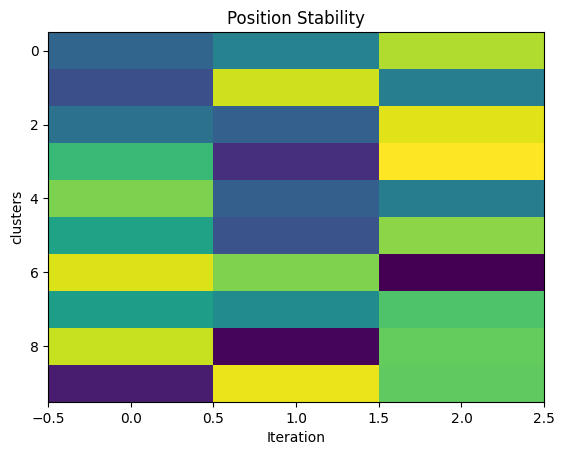

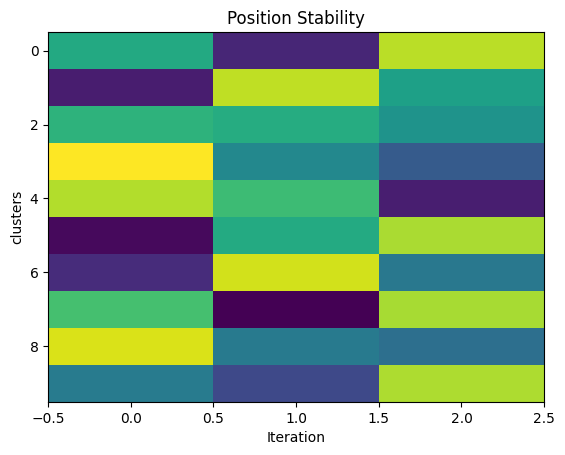

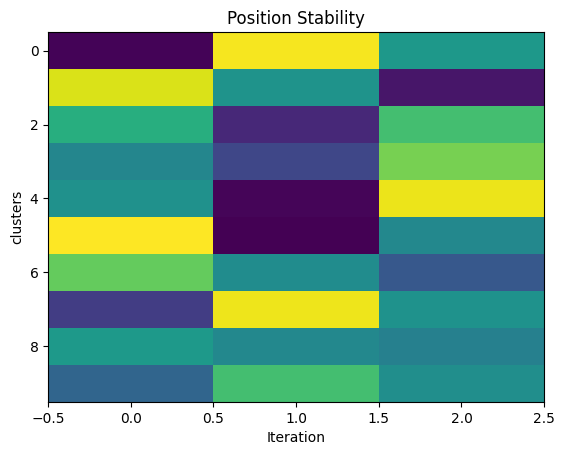

In [26]:
plot_centroid_stability(C)

Taille des clusters

Domaine d'application : Considérez la signification pratique des clusters dans le contexte de votre application. Parfois, un nombre spécifique de clusters peut avoir plus de sens en fonction de la nature des données et des objectifs de votre analyse.

In [27]:
df.columns

Index(['N', 'P', 'K', 'pH', 'EC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B'], dtype='object')

In [83]:
df['Cluster'] = instance_clusters

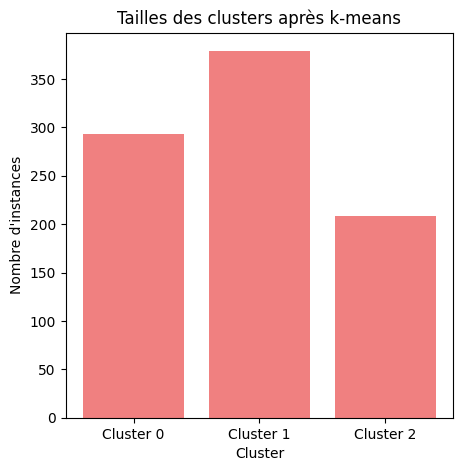

In [85]:
# Tailles des clusters après k-means
cluster_0_size = len(df[df['Cluster'] == 0])
cluster_1_size = len(df[df['Cluster'] == 1])
cluster_2_size = len(df[df['Cluster'] == 2])

# Affichage de l'histogramme des tailles de clusters
plt.figure(figsize=(5, 5))
plt.bar(range(3), [cluster_0_size, cluster_1_size, cluster_2_size], color='lightcoral')
plt.xticks(range(3), ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Tailles des clusters après k-means')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'instances')
plt.show()


Application d’algorithme de clustering basé densité (DBSCAN)

In [2]:
df = pd.read_csv('agriculture.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)

In [3]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None

    def fit(self, df):
        self.labels = [0] * len(df)
        cluster_id = 0
        self.core_samples = []  # Liste pour stocker les indices des points de base
        for i in range(len(df)):
            if self.labels[i] != 0:
                continue
            neighbors = self.get_neighbors(df, i)
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1  # Marquer comme bruit
            else:
                cluster_id += 1
                self.core_samples.append(i)  # Ajouter l'indice du point de base
                self.expand_cluster(df, i, neighbors, cluster_id)

    def get_neighbors(self, df, index):
        neighbors = []
        for i in range(len(df)):
            if self.distance(df.iloc[index], df.iloc[i]) < self.eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(self, df, index, neighbors, cluster_id):
        self.labels[index] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if self.labels[neighbor] == -1:
                self.labels[neighbor] = cluster_id
            elif self.labels[neighbor] == 0:
                self.labels[neighbor] = cluster_id
                new_neighbors = self.get_neighbors(df, neighbor)
                if len(new_neighbors) >= self.min_samples:
                    neighbors = neighbors + new_neighbors
            i += 1

    def distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)

    def calculate_intra_cluster_density(self, df):
        intra_cluster_density = 0
        total_points = len(df)

        for i in range(total_points):
            if self.labels[i] != -1:  # Ignore les points de bruit
                neighbors = self.get_neighbors(df, i)
                intra_cluster_density += len(neighbors)

        # Calcul de la densité moyenne
        core_points_count = len(self.core_samples)
        if core_points_count > 0:
            intra_cluster_density /= core_points_count

        return intra_cluster_density

    def calculate_inter_cluster_density(self, df):
        inter_cluster_density = 0
        total_points = len(df)

        for i in range(total_points):
            for j in range(i + 1, total_points):
                if self.labels[i] != self.labels[j]:  # Points dans des clusters différents
                    inter_cluster_density += 1 / self.distance(df.iloc[i], df.iloc[j])

        # Calcul de la densité moyenne
        if total_points > 1:
            inter_cluster_density /= (total_points * (total_points - 1) / 2)

        return inter_cluster_density


In [713]:
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [3, 5, 7]

df = pd.read_csv('agriculture.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)


results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps, min_samples)
        dbscan.fit(df)
        unique_labels = np.unique(dbscan.labels)
        if len(unique_labels) > 1:
            num_clusters = len(np.unique(dbscan.labels)) 
            silhouette_avg = silhouette_score(df, dbscan.labels)
            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': silhouette_avg, 'num_clusters': num_clusters})

In [875]:
table = PrettyTable()
table.field_names = ['eps', 'min_samples', 'silhouette_score', 'num_clusters']
for result in results:
    table.add_row([result['eps'], result['min_samples'], result['silhouette_score'], result['num_clusters']])
table

eps,min_samples,silhouette_score,num_clusters
0.5,3,-0.016808433440771976,5
0.5,5,0.11265926755615506,2
0.5,7,0.09762005605681674,2
0.5,8,0.09417316707969396,2
0.5,4,0.11546380593703394,2
0.5,6,0.10819336828439019,2
0.25,4,-0.16441219363182355,6
0.4,4,-0.2025545177658642,18
0.3,4,-0.21234676109906084,6
0.55,6,0.1592564480974156,2


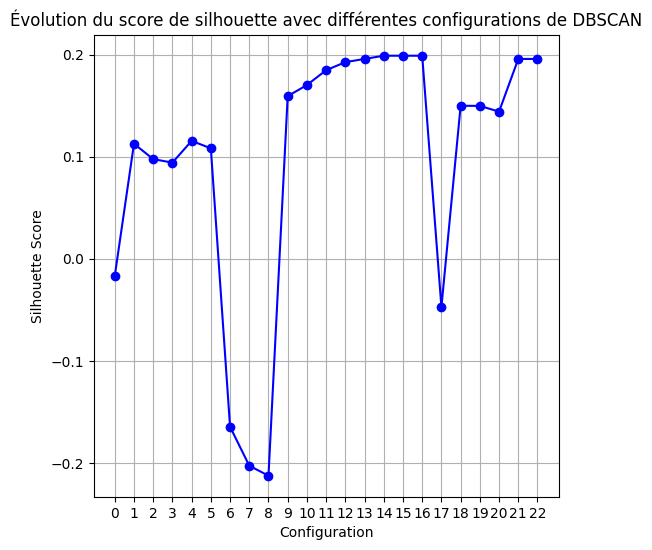

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

# Les données
data = {
    'eps': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.4, 0.3, 0.55, 0.56, 0.57, 0.58, 0.6, 0.62, 0.62, 0.65, 0.5, 0.54, 0.54, 0.54, 0.6, 0.6],
    'min_samples': [3, 5, 7, 8, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 5, 5, 2, 2, 5, 6, 6, 6, 4, 4, 2],
    'silhouette_score': [-0.016808433440771976, 0.11265926755615506, 0.09762005605681674, 0.09417316707969396, 0.11546380593703394, 0.10819336828439019, -0.16441219363182355, -0.2025545177658642, -0.21234676109906084, 0.1592564480974156, 0.17014799239765702, 0.18466390425725798, 0.1925633784052852, 0.19570174088471867, 0.1988413614843779, 0.1988413614843779, 0.1988413614843779, -0.047213262014522014, 0.14986561410313498, 0.14972334761838124, 0.14411172931453178, 0.19570174088471867, 0.19570174088471867],
    'num_clusters': [5, 2, 2, 2, 2, 2, 6, 18, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2]
}

# Assurez-vous que toutes les listes ont la même longueur
min_length = min(len(v) for v in data.values())
data = {k: v[:min_length] for k, v in data.items()}

df = pd.DataFrame(data)

# Tracer la courbe
plt.figure(figsize=(6, 6))
plt.plot(df.index, df['silhouette_score'], marker='o', linestyle='-', color='b')
plt.title('Évolution du score de silhouette avec différentes configurations de DBSCAN')
plt.xlabel('Configuration')
plt.ylabel('Silhouette Score')
plt.xticks(df.index)
plt.grid(True)
plt.show()


In [52]:
df = pd.read_csv('agriculture.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)
df.columns

Index(['N', 'P', 'K', 'pH', 'EC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B'], dtype='object')

In [53]:
eps=0.6
min_samples=6
dbscan = DBSCAN(eps, min_samples)
dbscan.fit(df)
silhouette_avg = silhouette_score(df, dbscan.labels)
num_clusters = len(np.unique(dbscan.labels)) 
print('eps ', eps, 'min_samples ', min_samples, 'silhouette_score ', silhouette_avg, 'num_clusters ', num_clusters)

eps  0.6 min_samples  6 silhouette_score  0.19570174088471867 num_clusters  2


In [182]:
df.columns

Index(['N', 'P', 'K', 'pH', 'EC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B',
       'DBSCAN_Labels', 'PCA1', 'PCA2'],
      dtype='object')

In [54]:
df['DBSCAN_Labels'] =dbscan.labels

In [55]:
df['DBSCAN_Labels'].unique()

array([ 1, -1], dtype=int64)

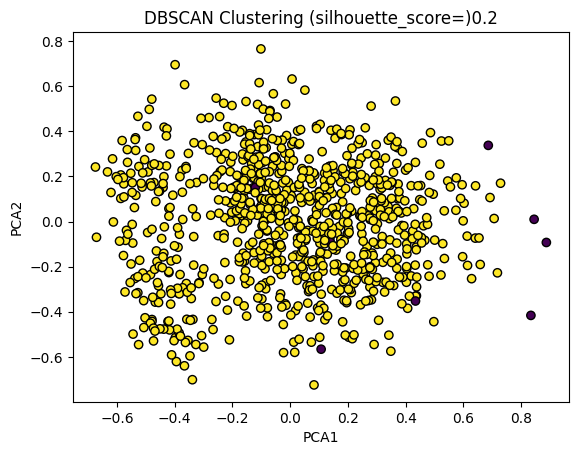

In [56]:
pca = PCA(n_components=2)

pca_result = pca.fit_transform(df)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.scatter(df['PCA1'], df['PCA2'], c=df['DBSCAN_Labels'], cmap='viridis', edgecolors='k')
plt.title(f'DBSCAN Clustering (silhouette_score=){round(silhouette_avg,2)}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


Comparaison K-means et DBSCAN 

In [74]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [223]:
#instance_clusters, centroides = k_means(instances, 3)
#df['Cluster'] = instance_clusters

In [76]:
h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(df1['Fertility'], df['Cluster'])
print(f'Homogeneity {round(h_kmeans,4)}, Completeness {round(c_kmeans,4)}, V_measure {round(v_kmeans,4)}')

Homogeneity 0.2512, Completeness 0.2032, V_measure 0.2246


In [192]:
#dbscan = DBSCAN(eps=1, min_samples=3)
#dbscan.fit(df)

In [188]:
from sklearn.metrics import adjusted_rand_score

# Comparer les résultats avec l'indice de Rand ajusté
rand_index = adjusted_rand_score(df['DBSCAN_Labels'], instance_clusters)
print(f"ARI between DBSCAN and K-Means: {rand_index}")


ARI between DBSCAN and K-Means: -0.003176776156441915


Inter-Cluster: mesure la séparation entre les clusters;
Intra-Cluster: mesure la cohésion à l'intérieur des clusters;
La silhouette mesure à quel point chaque point d'un cluster est similaire aux autres points de son propre cluster par rapport aux points des autres clusters;

In [811]:
def calculate_inter_intra_cluster_distances(instances, instance_clusters, centroides):
    k = len(centroides)

    # Calculer la distance intra-cluster (inertie)
    inertia = 0.0
    for i in range(len(instances)):
        cluster_index = instance_clusters[i]
        inertia += calcule_distance_euclidienne(instances[i], centroides[cluster_index])

    # Calculer la distance inter-cluster
    inter_cluster_distances = 0.0
    for i in range(k):
        for j in range(i + 1, k):
            inter_cluster_distances += calcule_distance_euclidienne(centroides[i], centroides[j])

    return inertia, inter_cluster_distances

In [812]:
# Calculer les distances inter et intra-cluster
inertia, inter_cluster_distances = calculate_inter_intra_cluster_distances(instances, instance_clusters, centroides)
print('K-means')
print(f"Intra-cluster Density : {inertia}")
print(f"Inter-Cluster Density : {inter_cluster_distances}")

K-means
Intra-cluster Density : 2604.930000000004
Inter-Cluster Density : 6.98


In [186]:
print('DBSCAN')
intra_density = dbscan.calculate_intra_cluster_density(df)
print("Intra-Cluster Density:", intra_density)

# Calcul de l'inter-cluster density
inter_density = dbscan.calculate_inter_cluster_density(df)
print("Inter-Cluster Density:", inter_density)

DBSCAN
Intra-Cluster Density: 18056.0
Inter-Cluster Density: 0.005260765713668523


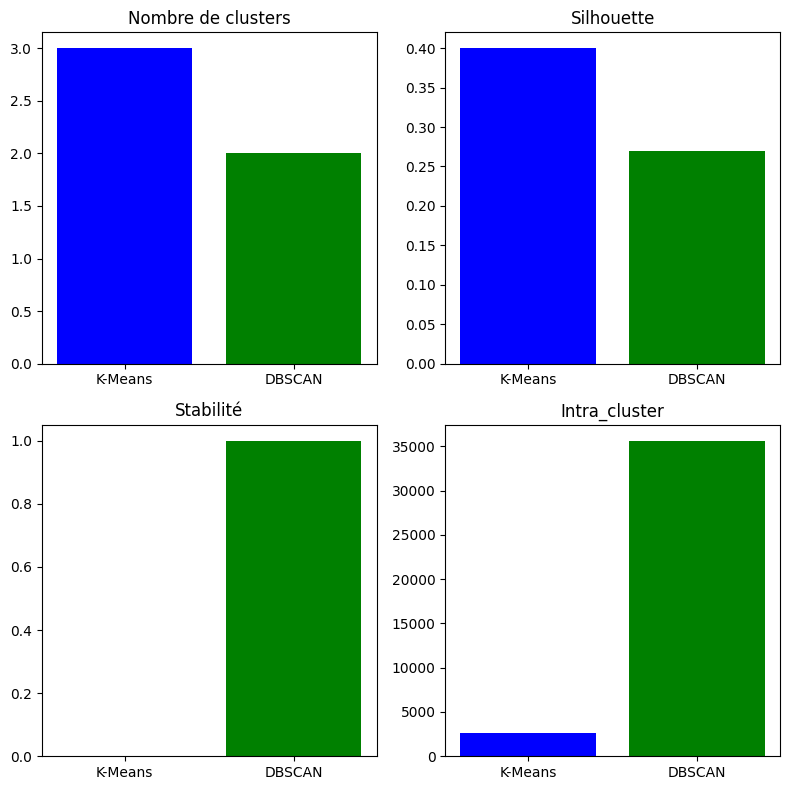

In [4]:
import matplotlib.pyplot as plt

# Données à comparer
algorithmes = ['K-Means', 'DBSCAN']
nombre_clusters = [3, 2]
silhouette = [0.40, 0.27]
stabilite = ['Non', 'Oui']
intra_cluster = [2604.93, 35642.0]
inter_cluster = [6.98, 0.020]

# Créer le graphique en barres
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Nombre de clusters
axs[0, 0].bar(algorithmes, nombre_clusters, color=['blue', 'green'])
axs[0, 0].set_title('Nombre de clusters')

# Silhouette
axs[0, 1].bar(algorithmes, silhouette, color=['blue', 'green'])
axs[0, 1].set_title('Silhouette')

# Stabilité
axs[1, 0].bar(algorithmes, [1 if s == 'Oui' else 0 for s in stabilite], color=['blue', 'green'])
axs[1, 0].set_title('Stabilité')

# Inter-cluster
axs[1, 1].bar(algorithmes, intra_cluster, color=['blue', 'green'])
axs[1, 1].set_title('Intra_cluster')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()
